In [1]:
import ndjson
import json
import os
import requests
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
import cv2
import csv
import torch
import clip
from PIL import Image
from collections import deque
import datetime
import csv
from pathlib import Path
from ultralytics import YOLO
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_curve, auc, confusion_matrix, RocCurveDisplay, ConfusionMatrixDisplay
)
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_distances

In [29]:
# path of the labelbox metadata file
META_DATA_PATH = 'Metadata/Export  project - Fred-Labels - 7_28_2025.ndjson'

# directory to download the videos
VIDEOS_DIRECTORY = r"jump_data\videos"

IMAGES_DIRECTORY = 'jump_data/images'

EMBEDDINGS_DIRECTORY = 'jump_data/image_embeddings'

CSV_PATH = 'car_jump_data.csv'

YOLO_MODEL_PATH = r"E:\VS Code Folders\yolo_training\runs\yolo11l.pt_2025-07-01_epochs_80_val_0.08\weights\best.pt"


In [24]:
def check_path(video_path):
    if not os.path.exists(video_path):
        os.makedirs(video_path)
        print(f"Path {video_path} has been created successfully..!!")
    else:
        print(f"Path {video_path} already exists..!!")

In [25]:
check_path(VIDEOS_DIRECTORY)
check_path(IMAGES_DIRECTORY)
check_path(EMBEDDINGS_DIRECTORY)

Path jump_data\videos already exists..!!
Path jump_data/images already exists..!!
Path jump_data/image_embeddings already exists..!!


In [6]:
LABELS = ['jump', 'no jump']

In [7]:
def download_video(video_url, video_name, video_path):
    """
    Downloads a video from the given URL and saves it with the specified name in the videos folder.
    
    Args:
        video_url (str): The URL of the video to be downloaded.
        video_name (str): The name of the video file.
        videos_folder (str): The path to the folder where the video will be saved.
    """
    if os.path.exists(video_path):
        print(f"Video '{video_path}' already exists. Skipping download.")
        return
    
    try:
        response = requests.get(video_url, stream=True)
        if response.status_code == 200:
            with open(video_path, 'wb') as file:
                for chunk in response.iter_content(chunk_size=1024):
                    file.write(chunk)
            print(f"Video '{video_name}' downloaded successfully.")
        else:
            print(f"Error downloading video '{video_name}': {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"Error downloading video '{video_name}': {e}")

In [8]:
def check_if_path_exists(path):
    if os.path.exists(path):
        print(f"Path: {path} already exists..!!")
        return True

In [9]:
def save_image(output_path, frame):
    if check_if_path_exists(output_path):
        print(f"Frame already exists at {output_path}")
        return False
    cv2.imwrite(output_path, frame)
    return True

In [10]:
def extract_frame_by_iteration(video_path, target_frame, output_path=None, save=False):
    if save and output_path and check_if_path_exists(output_path):
        print(f"Frame already exists at {output_path}")
        return cv2.imread(output_path)
    
    video = cv2.VideoCapture(video_path)
    if not video.isOpened():
        print("Error: Could not open video.")
        return None
    
    frame_count = 0
    success = True

    while success and frame_count <= target_frame:
        success, frame = video.read()
        frame_count += 1

        if frame_count == target_frame:
            if save and output_path:
                save_image(output_path, frame)
                print(f"Frame {target_frame} extracted and saved successfully.")
            else:
                print(f"Frame {target_frame} extracted successfully.")
            break

    if frame_count != target_frame:
        print(f"Error: Could not extract frame {target_frame}.")
        frame = None

    video.release()
    return frame

# Test
# extract_frame_by_iteration('videos/test.mp4', 105, 'images/test_105.png', True)

In [17]:
def is_jump(frame_idx, ranges):
    return any(start <= frame_idx <= end for start, end in ranges)

In [12]:
def run_yolo_on_frame(frame, model, conf_threshold=0.8):
    
    results = model(frame, verbose=False, classes=[0])[0]  # class 0 = car

    for box in results.boxes:
        if box.conf.item() > conf_threshold:
            return True  # At least one car detected

    return False  # No car detected above threshold


In [13]:
def load_yolo_model(path):
    """Load YOLO model from the specified path."""
    return YOLO(path, task='detect')

In [14]:
yolo_model = load_yolo_model(YOLO_MODEL_PATH)

In [15]:
# Check if file exists
file_exists = os.path.exists(CSV_PATH)
file_exists

False

In [30]:
# Check if file exists
file_exists = os.path.exists(CSV_PATH)

with open(CSV_PATH, 'a', newline='') as csvfile:  # 'a' mode = append
    writer = csv.writer(csvfile)
    
    if not file_exists:
        writer.writerow(["video", "image_label", "frame_number", "label"])  # Only write header if new file

    with open(META_DATA_PATH, 'r') as file:
        metadata = ndjson.load(file)

        for item in metadata:
            video_url = item['data_row']['row_data']
            video_name = item['data_row']['external_id']
            video_path = os.path.join(VIDEOS_DIRECTORY, video_name)

            frame_count = item['media_attributes']['frame_count']
            project_key = next(iter(item.get("projects", {})), None)
            if not project_key:
                continue

            frames = item["projects"][project_key]["labels"][0]["annotations"]["frames"]

            # 1. Collect all jump frames
            jump_list = []
            for frame_str, annotations in frames.items():
                if any(obj['value'] == 'jump' for obj in annotations['classifications']):
                    jump_list.append(int(frame_str))
            
            if not jump_list:
                continue

            download_video(video_url, video_name, video_path)

            jump_list.sort()

            # 2. Form jump ranges
            jump_ranges = []
            if len(jump_list) % 2 == 0:
                for i in range(0, len(jump_list), 2):
                    start = jump_list[i]
                    end = jump_list[i + 1]
                    jump_ranges.append((start, end))

            # 3. Write jump frames
            for start, end in jump_ranges:
                for frame_number in range(start, end + 1, 2):
                    image_label = f"{IMAGES_DIRECTORY}/{video_name[:-4]}_{frame_number}_1.png"
                    writer.writerow([video_name, image_label[17:], frame_number, 1])  # Label 1 = jump
                    extract_frame_by_iteration(video_path, frame_number, image_label, save=True)

            # 4. Sample every nth other frame
            for frame_number in range(1, frame_count, 15):
                if is_jump(frame_number, jump_ranges):
                    continue  # Already handled

                frame = extract_frame_by_iteration(video_path, frame_number)
                if frame is None:
                    continue

                detections = run_yolo_on_frame(frame, yolo_model)
                if (detections):
                    image_label = f"{IMAGES_DIRECTORY}/{video_name[:-4]}_{frame_number}_0.png"
                    if save_image(image_label, frame):
                        print(f"Frame {frame_number} saved successfully.")
                    writer.writerow([video_name, image_label[17:], frame_number, 0])  # Label 0 = no jump

Video 'converted_The Motorsport Hub .-7.3477769,55.3509653.1750417516.mp4' downloaded successfully.
Frame 100 extracted and saved successfully.
Frame 102 extracted and saved successfully.
Frame 104 extracted and saved successfully.
Frame 106 extracted and saved successfully.
Frame 108 extracted and saved successfully.
Frame 110 extracted and saved successfully.
Frame 112 extracted and saved successfully.
Frame 114 extracted and saved successfully.
Frame 116 extracted and saved successfully.
Frame 1 extracted successfully.
Frame 16 extracted successfully.
Frame 31 extracted successfully.
Frame 31 saved successfully.
Frame 46 extracted successfully.
Frame 46 saved successfully.
Frame 61 extracted successfully.
Frame 61 saved successfully.
Frame 76 extracted successfully.
Frame 76 saved successfully.
Frame 91 extracted successfully.
Frame 91 saved successfully.
Frame 121 extracted successfully.
Frame 136 extracted successfully.
Frame 151 extracted successfully.
Frame 166 extracted success

In [31]:
unique_rows = set()
deduplicated_rows = []

with open(CSV_PATH, 'r') as file:
    reader = csv.DictReader(file)
    fieldnames = reader.fieldnames  # Preserve headers

    for row in reader:
        row_tuple = tuple(row.items())  # Convert to a hashable type
        if row_tuple not in unique_rows:
            unique_rows.add(row_tuple)
            deduplicated_rows.append(row)

# Optional: Overwrite original CSV with deduplicated data
with open(CSV_PATH, 'w', newline='') as file:
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(deduplicated_rows)

In [32]:
jump_count = 0
no_jump_count = 0

with open(CSV_PATH, 'r') as file:
    reader = csv.DictReader(file)
    for row in reader:
        label = row['label'].strip()
        if label == '1':
            jump_count += 1
        elif label == '0':
            no_jump_count += 1

print(f"Jump frames (label=1): {jump_count}")
print(f"No Jump frames (label=0): {no_jump_count}")

Jump frames (label=1): 2951
No Jump frames (label=0): 3835


In [33]:
def load_clip_model():
    print("Loading OpenAI CLIP...")
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model, preprocess = clip.load("ViT-L/14@336px", device=device)
    model.eval()
    print(f"Model loaded on {device}.")
    return model, preprocess, device

In [34]:
clip_model, preprocess, device = load_clip_model()

Loading OpenAI CLIP...
Model loaded on cuda.


In [ ]:
images = os.listdir(IMAGES_DIRECTORY)

for image_name in images:
    image_path = os.path.join(IMAGES_DIRECTORY, image_name)

    # Skip non-image files
    if not image_name.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.webp')):
        continue

    emb_path = os.path.join(EMBEDDINGS_DIRECTORY, os.path.splitext(image_name)[0] + ".npy")

    if check_if_path_exists(emb_path):
        continue
    # Load and preprocess image
    bgr_img = cv2.imread(image_path)
    if bgr_img is None:
        print(f"Warning: Failed to load {image_name}")
        continue

    pil_image = Image.fromarray(cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB))
    img_tensor = preprocess(pil_image).unsqueeze(0).to(device)

    # Encode image with CLIP
    with torch.no_grad():
        img_feat = clip_model.encode_image(img_tensor)
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

    # Convert to numpy and save
    embedding = img_feat.squeeze(0).cpu().numpy()
    np.save(emb_path, embedding)
    

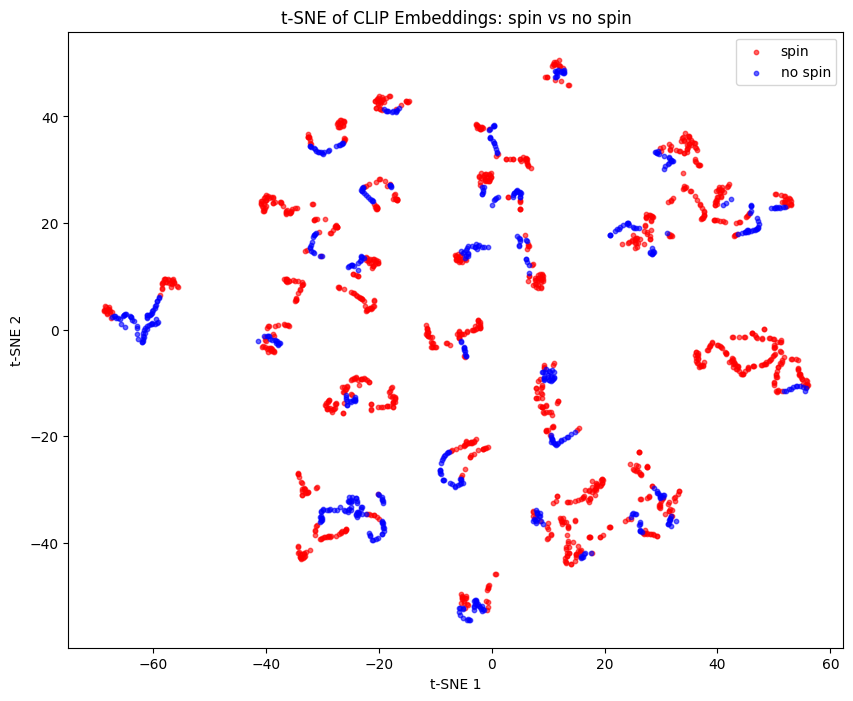

In [ ]:
embeddings = []
labels = []
label_names = []

with open(CSV_PATH, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        image_name = row['image_label']  # column name as in your CSV
        label = int(row['label'])
        embedding_file = os.path.splitext(image_name)[0] + '.npy'
        embedding_path = os.path.join(EMBEDDINGS_DIRECTORY, embedding_file)
        if os.path.exists(embedding_path):
            emb = np.load(embedding_path)
            embeddings.append(emb)
            labels.append(label)
            label_names.append(image_name)
        else:
            print(f"Missing embedding for {embedding_path}")

embeddings = np.array(embeddings)
labels = np.array(labels)

# t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10, 8))
colors = ['red', 'blue']
for label_value, color, label_str in zip([0, 1], colors, LABELS):
    idx = labels == label_value
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], c=color, label=label_str, alpha=0.6, s=10)

plt.legend()
plt.title('t-SNE of CLIP Embeddings: jump vs no jump')
plt.xlabel('t-SNE 1')
plt.ylabel('t-SNE 2')
plt.show()

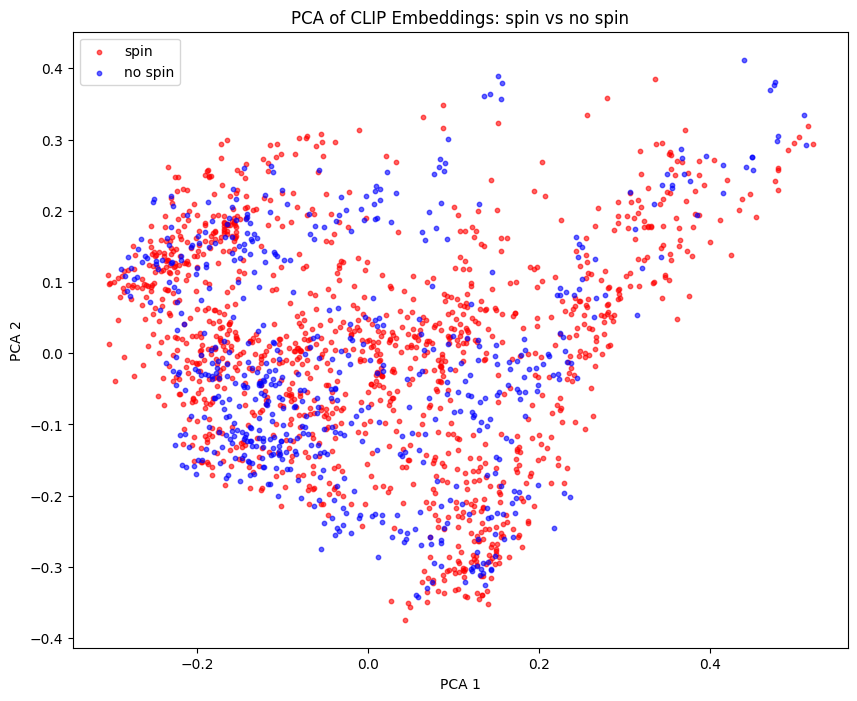

In [ ]:
pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot (reuse existing code)
plt.figure(figsize=(10, 8))
for label_value, color, label_str in zip([0, 1], colors, LABELS):
    idx = labels == label_value
    plt.scatter(embeddings_2d[idx, 0], embeddings_2d[idx, 1], c=color, label=label_str, alpha=0.6, s=10)

plt.legend()
plt.title('PCA of CLIP Embeddings: jump vs no jump')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()


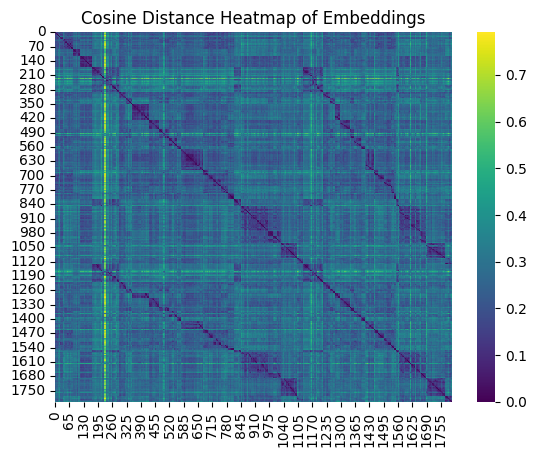

In [62]:
dist_matrix = cosine_distances(embeddings)
sns.heatmap(dist_matrix, cmap='viridis')
plt.title('Cosine Distance Heatmap of Embeddings')
plt.show()

In [63]:
# 1. Read CSV and group by video
video_to_rows = {}
with open(CSV_PATH, 'r') as f:
    reader = csv.DictReader(f)
    for row in reader:
        video = row['video']
        if video not in video_to_rows:
            video_to_rows[video] = []
        video_to_rows[video].append(row)

In [64]:
# 2. Split videos into train/val
videos = list(video_to_rows.keys())
train_videos, val_videos = train_test_split(videos, test_size=0.1, random_state=37)
print(f"Train videos: {len(train_videos)}")
print(f"Validation videos: {len(val_videos)}")

Train videos: 24
Validation videos: 3


In [65]:
def load_data(video_list):
    X, y = [], []
    for video in video_list:
        for row in video_to_rows[video]:
            image_name = row['image_label']
            label = int(row['label'])
            embedding_file = os.path.splitext(image_name)[0] + '.npy'
            embedding_path = os.path.join(EMBEDDINGS_DIRECTORY, embedding_file)
            if os.path.exists(embedding_path):
                emb = np.load(embedding_path)
                X.append(emb)
                y.append(label)
    return np.array(X), np.array(y)

In [66]:
# 3. Load embeddings and labels
X_train, y_train = load_data(train_videos)
X_val, y_val = load_data(val_videos)

print(f"Train samples: {len(y_train)}, Val samples: {len(y_val)}")

Train samples: 1594, Val samples: 212



Training Logistic Regression...
Validation Accuracy: 0.7123
              precision    recall  f1-score   support

     no spin       0.77      0.87      0.82       156
        spin       0.43      0.27      0.33        56

    accuracy                           0.71       212
   macro avg       0.60      0.57      0.57       212
weighted avg       0.68      0.71      0.69       212



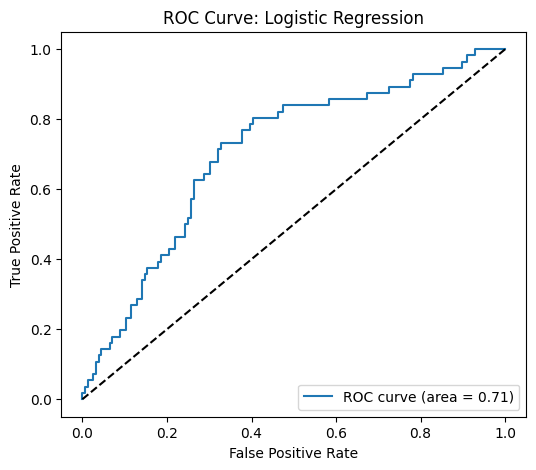

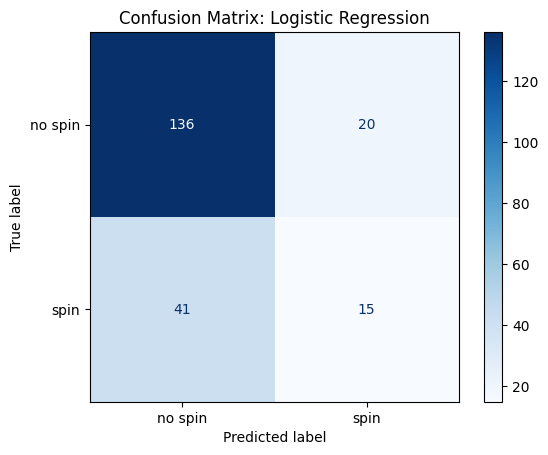


Training Linear SVM...
Validation Accuracy: 0.6840
              precision    recall  f1-score   support

     no spin       0.90      0.64      0.75       156
        spin       0.45      0.80      0.57        56

    accuracy                           0.68       212
   macro avg       0.67      0.72      0.66       212
weighted avg       0.78      0.68      0.70       212



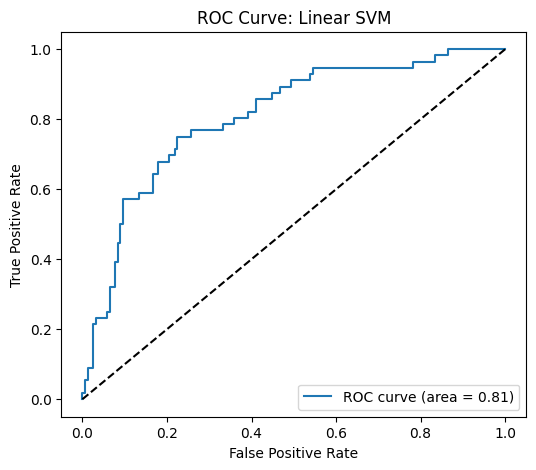

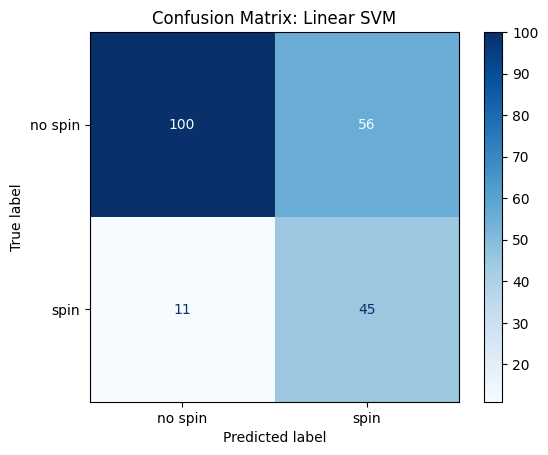


Training Kernel SVM (RBF)...
Validation Accuracy: 0.6651
              precision    recall  f1-score   support

     no spin       0.81      0.71      0.76       156
        spin       0.40      0.54      0.46        56

    accuracy                           0.67       212
   macro avg       0.61      0.62      0.61       212
weighted avg       0.70      0.67      0.68       212



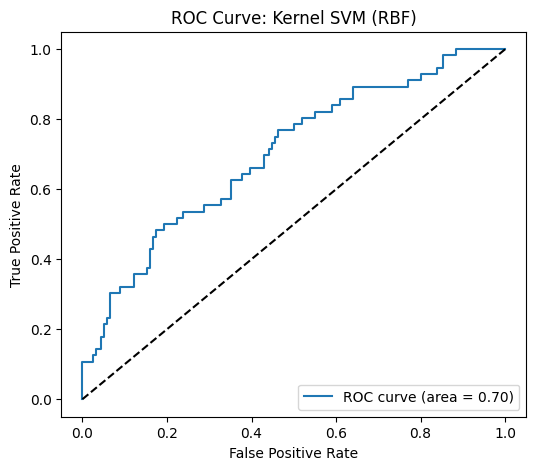

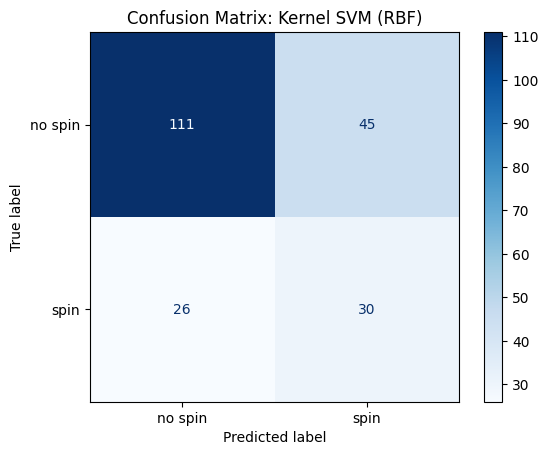


Training Polynomial SVM (degree 3)...
Validation Accuracy: 0.6981
              precision    recall  f1-score   support

     no spin       0.83      0.74      0.78       156
        spin       0.44      0.57      0.50        56

    accuracy                           0.70       212
   macro avg       0.64      0.66      0.64       212
weighted avg       0.73      0.70      0.71       212



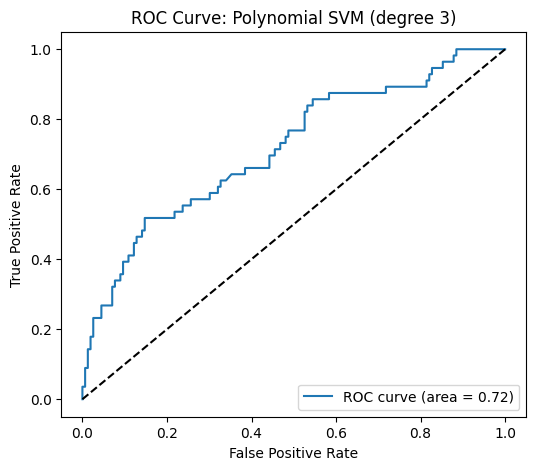

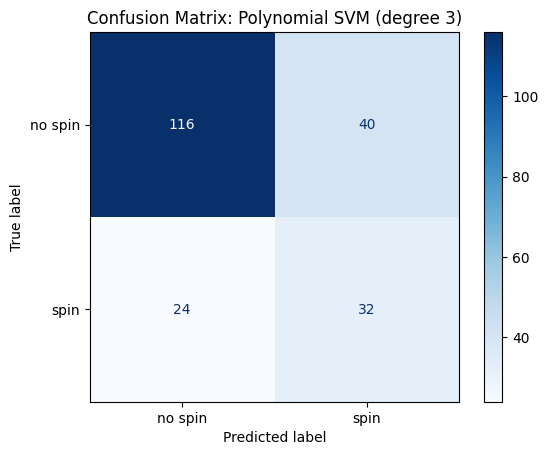


Training Sigmoid SVM...
Validation Accuracy: 0.7311
              precision    recall  f1-score   support

     no spin       0.75      0.96      0.84       156
        spin       0.45      0.09      0.15        56

    accuracy                           0.73       212
   macro avg       0.60      0.53      0.49       212
weighted avg       0.67      0.73      0.66       212



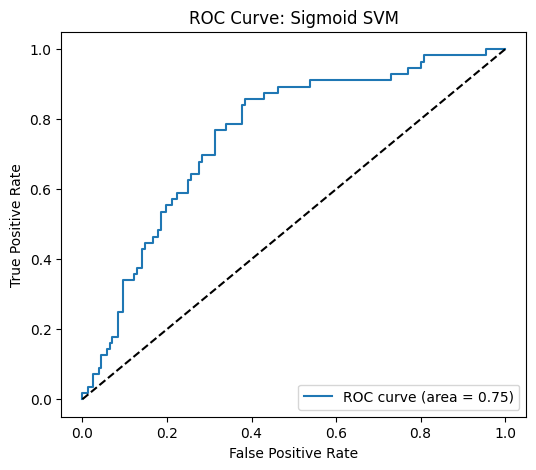

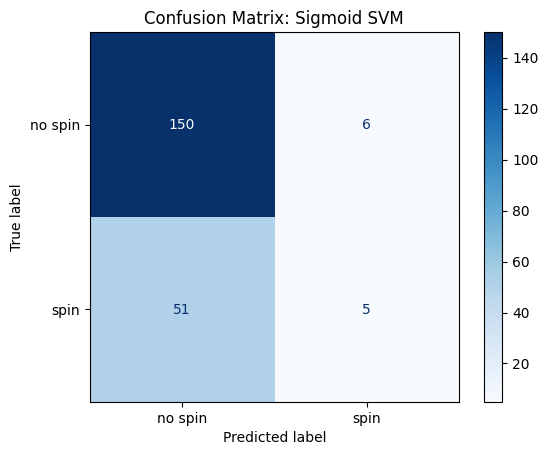


Training Random Forest...
Validation Accuracy: 0.7217
              precision    recall  f1-score   support

     no spin       0.75      0.93      0.83       156
        spin       0.42      0.14      0.21        56

    accuracy                           0.72       212
   macro avg       0.59      0.54      0.52       212
weighted avg       0.66      0.72      0.67       212



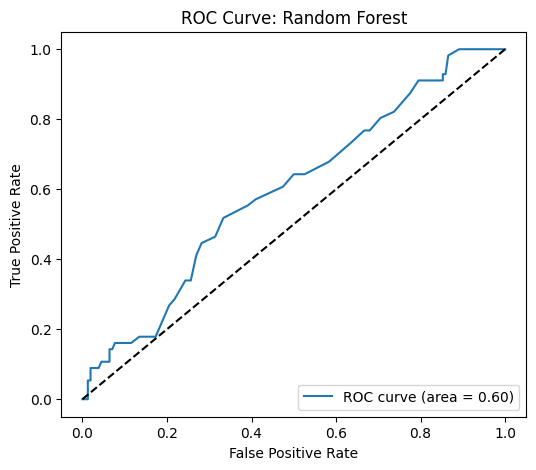

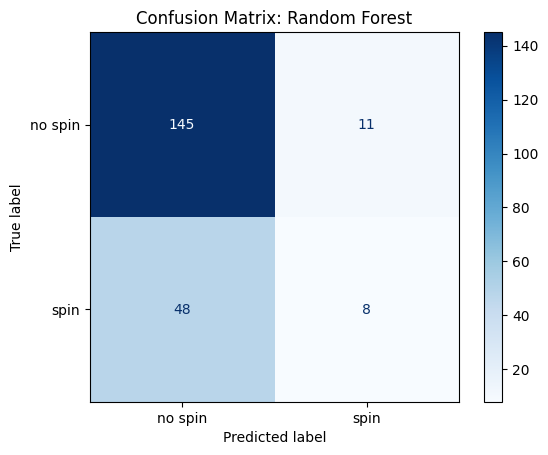


Training K-Nearest Neighbors...
Validation Accuracy: 0.5849
              precision    recall  f1-score   support

     no spin       0.75      0.65      0.70       156
        spin       0.29      0.41      0.34        56

    accuracy                           0.58       212
   macro avg       0.52      0.53      0.52       212
weighted avg       0.63      0.58      0.60       212



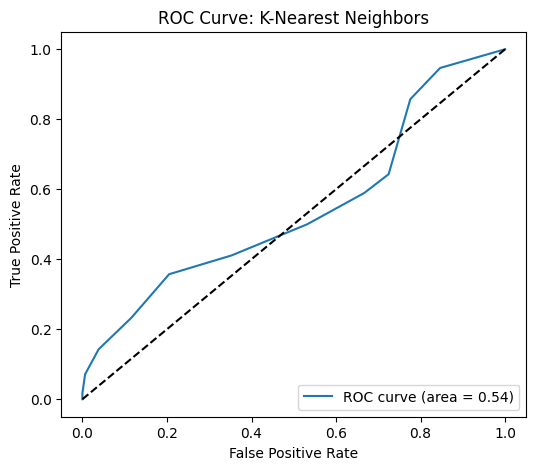

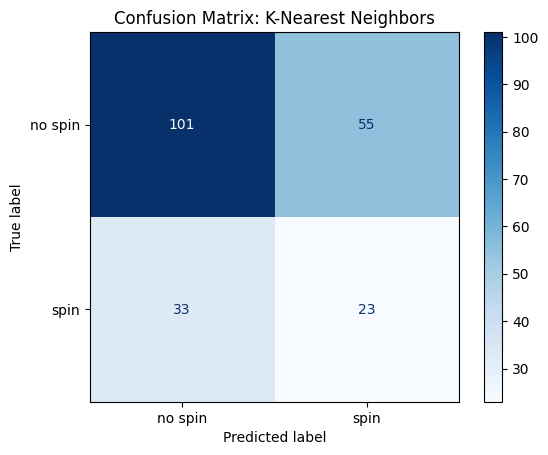


Summary of Validation Accuracies:
Logistic Regression: 0.7123
Linear SVM: 0.6840
Kernel SVM (RBF): 0.6651
Polynomial SVM (degree 3): 0.6981
Sigmoid SVM: 0.7311
Random Forest: 0.7217
K-Nearest Neighbors: 0.5849


In [ ]:
# Define classifiers
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(max_iter=10000),
    "Kernel SVM (RBF)": SVC(kernel='rbf', probability=True),
    "Polynomial SVM (degree 3)": SVC(kernel='poly', degree=3, probability=True),
    "Sigmoid SVM": SVC(kernel='sigmoid', probability=True),
    "Random Forest": RandomForestClassifier(n_estimators=200),
    # "Gradient Boosting": GradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=11)
}

results = {}

for name, clf in classifiers.items():
    print(f"\nTraining {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    acc = accuracy_score(y_val, y_pred)
    print(f"Validation Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_pred, target_names=['no spin', 'spin']))
    results[name] = acc

    # ROC Curve
    plt.figure(figsize=(6, 5))
    if hasattr(clf, "predict_proba"):
        y_score = clf.predict_proba(X_val)[:, 1]
    else:
        # For LinearSVC, use decision_function
        y_score = clf.decision_function(X_val)
    fpr, tpr, _ = roc_curve(y_val, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve: {name}')
    plt.legend(loc="lower right")
    plt.show()

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no jump', 'jump'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix: {name}')
    plt.show()


# Print summary
print("\nSummary of Validation Accuracies:")
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

In [73]:
clf = SVC(kernel='sigmoid', probability=True)
clf.fit(X_train, y_train)

SVC(kernel='sigmoid', probability=True)

In [74]:
# Video input/output paths
video_path = r"C:\Users\littl\Downloads\Screen Recording 2025-07-16 164803 (3).mov"
video_name = os.path.basename(video_path)
output_video_path = f"spins/{video_name}"

# Open video
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

# Writer to save output
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))

frame_count = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1

    # Convert frame to RGB and PIL
    pil_image = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    img_tensor = preprocess(pil_image).unsqueeze(0).to(device)

    # Get CLIP embedding
    with torch.no_grad():
        img_feat = clip_model.encode_image(img_tensor)
        img_feat = img_feat / img_feat.norm(dim=-1, keepdim=True)

    # Predict using SVM
    embedding_np = img_feat.squeeze(0).cpu().numpy().reshape(1, -1)
    pred = clf.predict(embedding_np)[0]
    prob = clf.predict_proba(embedding_np)[0].max()

    # Overlay prediction on frame
    label_text = f"{'spin' if pred == 1 else 'no spin'} ({prob:.2f})"
    cv2.putText(frame, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 
                1, (0, 255, 0) if pred == 1 else (0, 0, 255), 2)

    # Write frame to output video
    out.write(frame)

    # (Optional) Show live preview
    # cv2.imshow('Prediction', frame)
    # if cv2.waitKey(1) & 0xFF == ord('q'):
    #     break

cap.release()
out.release()
cv2.destroyAllWindows()
print("Done! Saved to:", output_video_path)

Done! Saved to: spins/Screen Recording 2025-07-16 164803 (3).mov


Zero-Shot CLIP Classifier Results:
Validation Accuracy: 0.7392996108949417
              precision    recall  f1-score   support

    no crash       0.89      0.52      0.65       244
       crash       0.68      0.94      0.79       270

    accuracy                           0.74       514
   macro avg       0.79      0.73      0.72       514
weighted avg       0.78      0.74      0.73       514



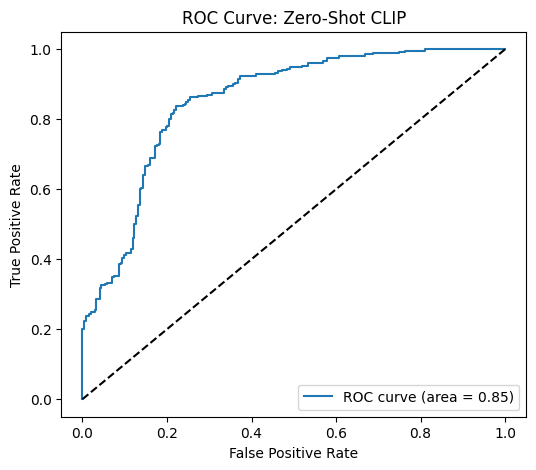

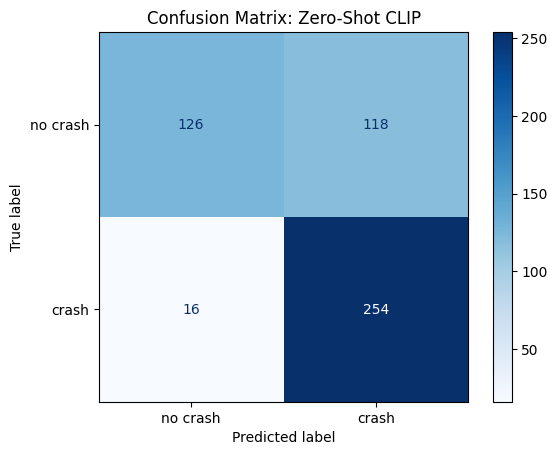

In [102]:
CRASH_PROMPTS = [
        "a photo of a rally car crashing into a barrier",
        "an image of a rally car colliding with a tree",
        "a picture of a rally car crashing into a ditch",
        "an image of a rally car losing control and rolling over",
        "a photo of a rally car veering off the road and crashing",
        "a picture of a rally car skidding and hitting a wall",
        "an image of a rally car spinning out and crashing",
        "a picture of a rally car hitting another vehicle",
        "a photo of a rally car crashing during a sharp turn",
        "an image of a rally car flipping after hitting a bump",
        "a picture of a rally car colliding with a pole",
        "a photo of a rally car crashing into a fence",
        "a picture of a rally car falling off a cliff",
        "an image of a rally car crashing into a spectator area",
        "a photo of a rally car hitting a rock and flipping",
        "a picture of a rally car crashing into a house",
        "an image of a rally car crashing into a bridge support",
        "a photo of a rally car exploding after a high-speed crash",
        "a picture of a rally car sliding into a body of water",
        "an image of a rally car catching fire after a crash"
]

NO_CRASH_PROMPTS = [
    "a photo of a rally car driving smoothly on a gravel road",
    "an image of a rally car drifting around a bend without crashing",
    "a picture of a rally car maintaining control at high speed",
    "an image of a rally car driving through a forest trail",
    "a photo of a rally car driving through shallow water",
    "a picture of a rally car passing a checkpoint on the track",
    "an image of a rally car following a race path without issues",
    "a picture of a rally car overtaking another car safely",
    "a photo of a rally car driving along a mountain road",
    "an image of a rally car navigating tight corners successfully",
    "a picture of a rally car accelerating on a straight stretch",
    "a photo of a rally car slowing down before a turn",
    "an image of a rally car going over a jump and landing safely",
    "a picture of a rally car calmly cruising on a dirt road",
    "a photo of a rally car on a tarmac rally stage"
]

all_prompts = CRASH_PROMPTS + NO_CRASH_PROMPTS
crash_count = len(CRASH_PROMPTS)

# 2. Encode text prompts
with torch.no_grad():
    text_tokens = clip.tokenize(all_prompts).to(device)
    text_features = clip_model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features = text_features.float()

# 3. Classify each validation embedding
y_pred_zeroshot = []
y_score_zeroshot = []

for emb in X_val:
    img_feat = torch.tensor(emb, dtype=torch.float32, device=device).unsqueeze(0)
    img_feat /= img_feat.norm(dim=-1, keepdim=True)
    with torch.no_grad():
        logits = 100.0 * img_feat @ text_features.T
        probs = logits.softmax(dim=-1).cpu().numpy()[0]
    prob_on = probs[:crash_count].sum()
    prob_off = probs[crash_count:].sum()
    y_pred_zeroshot.append(1 if prob_on > prob_off else 0)
    y_score_zeroshot.append(prob_on)  # Use prob_on as the "score" for ROC

y_pred_zeroshot = np.array(y_pred_zeroshot)
y_score_zeroshot = np.array(y_score_zeroshot)

# 4. Print metrics
print("Zero-Shot CLIP Classifier Results:")
print("Validation Accuracy:", accuracy_score(y_val, y_pred_zeroshot))
print(classification_report(y_val, y_pred_zeroshot, target_names=['no crash', 'crash']))

# 5. ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_score_zeroshot)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Zero-Shot CLIP')
plt.legend(loc="lower right")
plt.show()

# 6. Confusion Matrix
cm = confusion_matrix(y_val, y_pred_zeroshot)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['no crash', 'crash'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix: Zero-Shot CLIP')
plt.show()
